In [31]:
from sympy import *
from sympy.plotting import plot
import networkx as nx
import drawSvg as draw
import time


circle_color = "#DEB887"
crease_color = "red"
polygon_color = "black"
precision = 1
scale = 1
line_thickness = 10
viewport = 500
step = 20


def max_val (points):
    x = 0
    y = 0
    for point in points: 
        if point.x > x: x = point.x
        if point.y > y: y = point.y
    return float(x),float(y)
def drawCrease(cr,d):
    d.append(draw.Line(cr.p1.x,cr.p1.y,cr.p2.x,cr.p2.y, stroke= crease_color,stroke_width=line_thickness))
def drawCircle(c,d):
    d.append(draw.Circle(float(c.center.x),float(c.center.y),c.radius, fill= circle_color))
def drawPoly(p,d):
    path = draw.Path(stroke=polygon_color, stroke_width=line_thickness, fill='none')
    path.M(float(p.vertices[0].x), float(p.vertices[0].y))
    [path.L(float(v.x),float(v.y)) for v in p.vertices]
    path.L(float(p.vertices[0].x), float(p.vertices[0].y))
    d.append(path)

def shrink_polygon(polygon,sweep_length,creases=[]):
    print("angles: ", polygon.angles)
    for vertex in polygon.vertices:
        print("i: ", i, ", angle: ", float(polygon.angles[vertex]))
    print("bisectors: ",polygon.bisectors())
    #for side in polygon.sides:
        
    l1 = Line(polygon.vertices[0],polygon.vertices[1])
    l_perp = l1.parallel_line(Point(polygon.vertices[0].x,polygon.vertices[0].y))
    l_p = l1.parallel_line(Point(polygon.vertices[0].x + sweep_length,polygon.vertices[0].y+sweep_length))
    print(l1)
    print(l_p)
    print(l_perp)
    #print(l_p)
    
    
    #b = polygon.bisectors()
    #new_vertices = []
    #for vertex in polygon.vertices:
    #    new_vertex = vertex.translate((b[vertex].direction*sweep_length).x,(b[vertex].direction*sweep_length).y).evalf()
    #    creases.append(Line(new_vertex, vertex))
    #    new_vertices.append(new_vertex)
    #return Polygon(*new_vertices), creases

def render(points,circles,creases,polys):
    w,h = max_val(points)
    d = draw.Drawing (w,h)
    d.setRenderSize(viewport,viewport*h/w)
    for c in circles: drawCircle(c,d) 
    for poly in lang_polys: drawPoly(poly,d)
    for crease in creases: drawCrease(crease,d)
    return d
    
T = nx.Graph()

raw_points = Point(0,600,evaluate=False), Point(0,3600,evaluate=False), Point(1908,0,evaluate=False),Point(1908,3000,evaluate=False), Point(3816,600,evaluate=False), Point(3816,3600,evaluate=False)
points = [p*scale for p in raw_points]

# TODO add tree nodes with the right egde lengths
for point in points:
    T.add_node(point)
#T.add_edge()

# TODO: make the size of circles the length in the tree
circles = [Circle(point,1000*scale) for point in points]

#TODO figure out again where the polygons come from
lang_polys = [convex_hull(*points[:4]),convex_hull(*points[2:])]

original = lang_polys[0]

lang_polys[0],creases = shrink_polygon(lang_polys[0],step)
lang_polys.append(original)


for i in range (20):
    lang_polys[0],creases = shrink_polygon(lang_polys[0],step,creases)
render(points,circles,creases,lang_polys)




angles:  {Point2D(0, 3600): acos(50*sqrt(27781)/27781), Point2D(0, 600): acos(-50*sqrt(27781)/27781), Point2D(1908, 0): acos(50*sqrt(27781)/27781), Point2D(1908, 3000): acos(-50*sqrt(27781)/27781)}
i:  19 , angle:  1.8754707422931802
i:  19 , angle:  1.2661219112966131
i:  19 , angle:  1.8754707422931802
i:  19 , angle:  1.2661219112966131
bisectors:  {Point2D(0, 3600): Ray2D(Point2D(0, 3600), Point2D(sin(acos(50*sqrt(27781)/27781)/2), 3600 - cos(acos(50*sqrt(27781)/27781)/2))), Point2D(0, 600): Ray2D(Point2D(0, 600), Point2D(sqrt(27781)*(50*sin(acos(-50*sqrt(27781)/27781)/2) + 159*cos(acos(-50*sqrt(27781)/27781)/2))/27781, sqrt(27781)*(-50*cos(acos(-50*sqrt(27781)/27781)/2) + 159*sin(acos(-50*sqrt(27781)/27781)/2))/27781 + 600)), Point2D(1908, 0): Ray2D(Point2D(1908, 0), Point2D(1908 - sin(acos(50*sqrt(27781)/27781)/2), cos(acos(50*sqrt(27781)/27781)/2))), Point2D(1908, 3000): Ray2D(Point2D(1908, 3000), Point2D(-sqrt(27781)*(50*sin(acos(-50*sqrt(27781)/27781)/2) + 159*cos(acos(-50*sqr

TypeError: cannot unpack non-iterable NoneType object

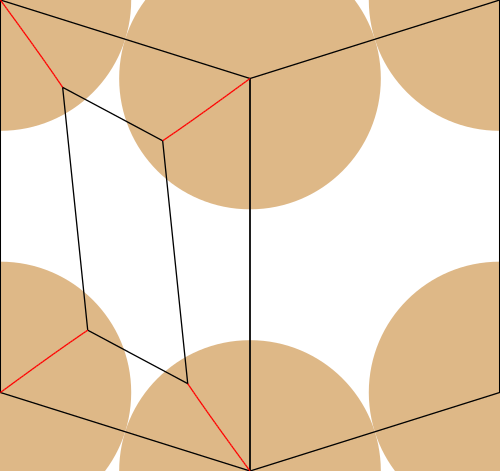

In [19]:
for i in range (20):
    lang_polys[0],creases = shrink_polygon(lang_polys[0],step,creases)
render(points,circles,creases,lang_polys)